In [57]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

import sys

sys.path.append("../stochman/")

from stochman import nnj

# Define convolution parameters

In [58]:
def compute_output_edge(input_edge, kernel_size=1,padding=0,stride=1,dilation=1):
    output_edge = ( input_edge - dilation*(kernel_size-1) + 2*padding -1 )/stride +1 #output edge can be not-integer if stride!=1
    return int(output_edge)
def compute_output_padding(input_edge, output_edge, kernel_size=1,padding=0,stride=1,dilation=1):
    return input_edge - ((output_edge-1)*stride - 2*padding + dilation*(kernel_size-1) + 1)
def compute_reversed_padding(padding, kernel_size=1):
    return kernel_size - 1 - padding
##############################################################################
##############################################################################
##############################################################################
# Set parameters (free to change)
batch_size = 11
IN_c, OUT_c = 3, 5 #number of channels (for input and output)
IN_h, IN_w = 20, 23 #number of pixels per input edges
kernel_h, kernel_w = 7, 8
set_padding_for_shape_preserving = False #not needed
if set_padding_for_shape_preserving:
    assert kernel_h%2==1 and kernel_w%2==1
    padding_h, padding_w = int((kernel_h-1)/2), int((kernel_w-1)/2)
else:
    padding_h, padding_w = 1, 4
stride = 1 #don't change me please, bad things will happen
dilation = 1

##############################################################################
# Compute output sizes
OUT_h, OUT_w = compute_output_edge(IN_h, kernel_size=kernel_h, padding=padding_h, stride=stride, dilation=dilation), compute_output_edge(IN_w, kernel_size=kernel_w, padding=padding_w, stride=stride, dilation=dilation)
# Compute output padding for conv transpose
out_padding_h, out_padding_w = compute_output_padding(IN_h, OUT_h, kernel_size=kernel_h, padding=padding_h, stride=stride, dilation=dilation), compute_output_padding(IN_w, OUT_w, kernel_size=kernel_w, padding=padding_w, stride=stride, dilation=dilation)
dw_padding_h, dw_padding_w = compute_reversed_padding(padding_h, kernel_size=kernel_h), compute_reversed_padding(padding_w, kernel_size=kernel_w)
dw_reversed_padding_h, dw_reversed_padding_w = compute_reversed_padding(padding_h, kernel_size=IN_h), compute_reversed_padding(padding_w, kernel_size=IN_w)
print(out_padding_h, out_padding_w)
##############################################################################
##############################################################################
##############################################################################
# Define convolutional layer
conv = nnj.Conv2d(IN_c, 
                  OUT_c, 
                  kernel_size=(kernel_h, kernel_w), 
                  padding=(padding_h,padding_w), 
                  stride=stride, dilation=dilation, bias=None)
assert list(conv.weight.shape) == [OUT_c, IN_c, kernel_h, kernel_w]
# Define input images. Compute output images
inputs = torch.randint(0, 10, (batch_size, IN_c, IN_h, IN_w)).type(torch.float)
outputs = conv(inputs)
assert list(outputs.shape) == [batch_size, OUT_c, OUT_h, OUT_w]
print('conv: \t\t\t weights',conv.weight.shape, '\t- input',inputs.shape, '\t- output',outputs.shape)

# Define reversed convolutional layer (same operator as conv but with switched input/weights)
conv_dw = nnj.ConvTranspose2d(IN_c, 
                              batch_size, 
                              kernel_size=(IN_h,IN_w), 
                              padding=(dw_padding_h,dw_padding_w), 
                              stride=stride, dilation=dilation, output_padding=0, bias=None)
reversed_inputs = torch.flip(inputs, [-2,-1]).movedim(0,1)
assert conv_dw.weight.shape == reversed_inputs.shape
conv_dw.weight = torch.nn.Parameter(reversed_inputs)
dw_outputs = torch.flip(conv_dw(conv.weight), [-2,-1]).movedim(0,1)
assert torch.max(dw_outputs - outputs) < 1e-5 #chek that the two operators are actually the same
print('conv_dw: \t\t weights',conv_dw.weight.shape, '\t- input',conv.weight.shape, '\t- output',dw_outputs.shape)




# Define transposed of convolutional layer
conv_transposed = nnj.ConvTranspose2d(OUT_c, 
                                      IN_c, 
                                      kernel_size=(kernel_h,kernel_w), 
                                      padding=(padding_h,padding_w), 
                                      stride=stride, dilation=dilation, bias=None, 
                                      output_padding=(out_padding_h,out_padding_w))
conv_transposed.weight = conv.weight
assert conv_transposed(outputs).shape == inputs.shape
print('conv_transposed: \t weights',conv_transposed.weight.shape, '\t- input',outputs.shape, '\t- output',conv_transposed(outputs).shape)

# Define reversed transposed convolutional layer
# maps:
#   from - output space
#   to - weight space
conv_dw_transposed = nnj.Conv2d(batch_size, 
                                IN_c, 
                                kernel_size=(IN_h,IN_w), 
                                padding=(dw_padding_h,dw_padding_w), 
                                stride=stride, dilation=dilation, bias=None) # output_padding=0
reversed_inputs = torch.flip(inputs, [-2,-1]).movedim(0,1)
assert conv_dw_transposed.weight.shape == reversed_inputs.shape
conv_dw_transposed.weight = torch.nn.Parameter(reversed_inputs)
dw_weights = torch.flip(conv_dw_transposed(outputs.movedim(0,1)), [-2,-1])
print('conv_dw_transposed: \t weights',conv_dw_transposed.weight.shape, '\t- input',outputs.movedim(0,1).shape, '\t- output',dw_weights.shape)

0 0
conv: 			 weights torch.Size([5, 3, 7, 8]) 	- input torch.Size([11, 3, 20, 23]) 	- output torch.Size([11, 5, 16, 24])
conv_dw: 		 weights torch.Size([3, 11, 20, 23]) 	- input torch.Size([5, 3, 7, 8]) 	- output torch.Size([11, 5, 16, 24])
conv_transposed: 	 weights torch.Size([5, 3, 7, 8]) 	- input torch.Size([11, 5, 16, 24]) 	- output torch.Size([11, 3, 20, 23])
conv_dw_transposed: 	 weights torch.Size([3, 11, 20, 23]) 	- input torch.Size([5, 11, 16, 24]) 	- output torch.Size([5, 3, 7, 8])


# Jacobian of convolution [wrt. input]
Computation of the full Jacobian (we don't want to do that)

In [59]:
IN_size, OUT_size = IN_c*IN_h*IN_w, OUT_c*OUT_h*OUT_w

def conv_jacobian_wrt_input():
    # define base elements on input, one for each batch size
    output_identity = torch.eye(IN_size).unsqueeze(0).expand(batch_size,-1,-1)
    assert list(output_identity.shape) == [batch_size, IN_size, IN_size]
    # expand rows as cubes [(input channel)x(input height)x(input width)]
    output_identity = output_identity.reshape(batch_size, IN_c, IN_h, IN_w, IN_size)
    # define the shapes required by torch.conv2d
    #  - from cube [(input channel)x(input height)x(input width)]
    #  - to cube   [(output channel)x(output height)x(output width)]
    input_for_shape = torch.zeros(batch_size,IN_c,IN_h,IN_w)
    output_for_shape = torch.zeros(batch_size,OUT_c,OUT_h,OUT_w)
    # convolve each base element and compute the jacobian
    jacobian = conv._jacobian_mult(input_for_shape, output_for_shape, output_identity)
    # reshape as a (num of output)x(num of input) matrix, one for each batch size
    jacobian = jacobian.reshape(batch_size, OUT_size, IN_size)
    return jacobian

def conv_jacobian_wrt_input_T():
    # define base elements on output, one for each batch size
    output_identity = torch.eye(OUT_size).unsqueeze(0).expand(batch_size,-1,-1)
    assert list(output_identity.shape) == [batch_size, OUT_size, OUT_size]
    # expand rows as cubes [(output channel)x(output height)x(output width)]
    output_identity = output_identity.reshape(batch_size, OUT_c, OUT_h, OUT_w, OUT_size)
    # define the shapes required by torch.conv2d (transposed)
    #  - from cube [(output channel)x(output height)x(output width)]
    #  - to cube   [(input channel)x(input height)x(input width)]
    input_for_shape = torch.zeros(batch_size,OUT_c,OUT_h,OUT_w)
    output_for_shape = torch.zeros(batch_size,IN_c,IN_h,IN_w)
    # convolve each base element and compute the jacobian
    jacobian = conv_transposed._jacobian_mult(input_for_shape, output_for_shape, output_identity)
    # reshape as a (num of input)x(num of output) matrix, one for each batch size
    jacobian = jacobian.reshape(batch_size, IN_size, OUT_size)
    return jacobian

# the two functions should return the same matrix, but transposed

# check if the shape are one the transposed of the other
print(conv_jacobian_wrt_input().shape, conv_jacobian_wrt_input_T().shape)
assert conv_jacobian_wrt_input().shape == conv_jacobian_wrt_input_T().movedim(-1,-2).shape
# check if the elements are the same
assert torch.max( conv_jacobian_wrt_input() - conv_jacobian_wrt_input_T().movedim(-1,-2) ) < 1e-5

torch.Size([11, 1920, 1380]) torch.Size([11, 1380, 1920])


# Jacobian of convolution [wrt. weights]

In [60]:
def conv_jacobian_wrt_weight():
    # define base elements on weights
    output_identity = torch.eye(OUT_c*IN_c*kernel_h*kernel_w)
    # expand rows as [(input channels)x(kernel height)x(kernel width)] cubes, one for each output channel
    output_identity = output_identity.reshape(OUT_c, IN_c,kernel_h,kernel_w, OUT_c*IN_c*kernel_h*kernel_w)
    # define the shapes required by torch.conv2d (transposed)
    #  - from cube [(input channels)x(kernel height)x(kernel width)]
    #  - to cube   [(batch size)x(output height)x(output width)]
    # one for each output channel
    input_for_shape = torch.zeros(OUT_c,IN_c,kernel_h,kernel_w)
    output_for_shape = torch.zeros(OUT_c,batch_size,OUT_h,OUT_w)
    # convolve each base element and compute the jacobian
    jacobian = conv_dw._jacobian_mult(input_for_shape, output_for_shape, output_identity)
    # transpose the result in (output height)x(output width)
    jacobian = torch.flip(jacobian, [-3, -2])
    # switch batch size and output channel
    jacobian = jacobian.movedim(0,1)
    # reshape as a (num of output)x(num of weights) matrix, one for each batch size
    jacobian = jacobian.reshape(batch_size, OUT_size, OUT_c*IN_c*kernel_h*kernel_w)
    return jacobian

matrix_operator_from_input_to_output = conv_jacobian_wrt_input()
output_computed_classically = torch.einsum('Bij,Bj->Bi',matrix_operator_from_input_to_output , inputs.reshape(batch_size,IN_size) ).reshape(batch_size,OUT_c,OUT_h,OUT_w)
matrix_operator_from_weight_to_output = conv_jacobian_wrt_weight()
output_computed_reversed = torch.einsum('Bij,j->Bi', matrix_operator_from_weight_to_output, conv.weight.reshape(-1)).reshape(batch_size,OUT_c,OUT_h,OUT_w)
# check that conv and conv_dw actually represent the same operator
assert torch.max(output_computed_classically - output_computed_reversed) < 1e-5

def conv_jacobian_wrt_weight_T():
    # define base elements on output, one for each batch size
    output_identity = torch.eye(batch_size*OUT_size)
    # expand rows as cubes [(output channel)x(output height)x(output width)]
    output_identity = output_identity.reshape(batch_size, OUT_c, OUT_h, OUT_w, batch_size*OUT_size)
    # transpose the images in (output height)x(output width)
    output_identity = torch.flip(output_identity, [-3, -2])
    # switch batch size and output channel
    output_identity = output_identity.movedim(0,1)
    # define the shapes required by torch.conv2d
    #  - from cube [(batch size)x(output height)x(output width)]
    #  - to cube   [(input channels)x(kernel height)x(kernel width)]
    input_for_shape = torch.zeros(OUT_c,batch_size,OUT_h,OUT_w)
    output_for_shape = torch.zeros(OUT_c,IN_c,kernel_h,kernel_w)
    # convolve each base element and compute the jacobian
    jacobian = conv_dw_transposed._jacobian_mult(input_for_shape, output_for_shape, output_identity)
    # reshape as a (num of weights)x(num of output) matrix
    jacobian = jacobian.reshape(OUT_c*IN_c*kernel_h*kernel_w, batch_size, OUT_size)
    # switch batch size and kernel size
    jacobian = jacobian.movedim(0,1)
    return jacobian

# the two functions should return the same matrix, but transposed

# check if the shape are one the transposed of the other
print(conv_jacobian_wrt_weight().shape, conv_jacobian_wrt_weight_T().shape)
assert conv_jacobian_wrt_weight().shape == conv_jacobian_wrt_weight_T().movedim(-1,-2).shape
# check if the elements are the same
assert torch.max( conv_jacobian_wrt_weight() - conv_jacobian_wrt_weight_T().movedim(-1,-2) ) < 1e-5


torch.Size([11, 1920, 840]) torch.Size([11, 840, 1920])


# Assert jacobian wrt weights is correct
Comparing to row-by-row computation (single layer NN, for now)

In [61]:
from asdfghjkl.gradient import batch_gradient

def _flatten_after_batch(tensor: torch.Tensor):
    if tensor.ndim == 1:
        return tensor.unsqueeze(-1)
    else:
        return tensor.flatten(start_dim=1)
        
def _get_batch_grad(model):
    batch_grads = list()
    for module in model.modules():
        if hasattr(module, 'op_results'):
            res = module.op_results['batch_grads']
            if 'weight' in res:
                batch_grads.append(_flatten_after_batch(res['weight']))
            if 'bias' in res:
                batch_grads.append(_flatten_after_batch(res['bias']))
            if len(set(res.keys()) - {'weight', 'bias'}) > 0:
                raise ValueError(f'Invalid parameter keys {res.keys()}')
    return torch.cat(batch_grads, dim=1)
    
def jacobians(x, model, output_channel, output_h, output_w):
    """Compute Jacobians \\(\\nabla_\\theta f(x;\\theta)\\) at current parameter \\(\\theta\\)
    using asdfghjkl's gradient per output dimension.
    Parameters
    ----------
    x : torch.Tensor
        input data `(batch, input_shape)` on compatible device with model.
    Returns
    -------
    Js : torch.Tensor
        Jacobians `(batch, parameters, outputs)`
    f : torch.Tensor
        output function `(batch, outputs)`
    """
    Js = list()
    for c in range(output_channel):
        for i in range(output_h):
            for j in range(output_w):
                def loss_fn(outputs, targets):
                    return outputs[:, c, i, j].sum()

                f = batch_gradient(model, loss_fn, x, None).detach()
                Jk = _get_batch_grad(model)

                Js.append(Jk)
    Js = torch.stack(Js, dim=1)
    return Js, f

# the two functions should return the same matrix
jacobian_wrt_weight_slow, _ = jacobians(inputs, conv, OUT_c, OUT_h, OUT_w)
jacobian_wrt_weight_fast = conv_jacobian_wrt_weight()

# check if the shape are the same
assert jacobian_wrt_weight_slow.shape == jacobian_wrt_weight_fast.shape
# check if the elements are the same
assert torch.max( jacobian_wrt_weight_slow - jacobian_wrt_weight_fast) < 1e-5


# Right and Left multiplications (J wrt to input)

In [62]:
def conv_jacobian_wrt_input_T_right_multiply_to(tmp):
    """
    Compute Jacobian^T * tmp

    Parameters
    ----------
    tmp : torch.Tensor
        input data `(batch_size, OUT_size, num_of_cols)`
    Returns
    -------
    product : torch.Tensor
        Jacobians `(batch_size, IN_size, num_of_cols)`
    """
    num_of_cols = tmp.shape[-1]
    assert list(tmp.shape) == [batch_size, OUT_size, num_of_cols]
    # expand rows as cubes [(output channel)x(output height)x(output width)]
    tmp = tmp.reshape(batch_size, OUT_c, OUT_h, OUT_w, num_of_cols)
    # define the shapes required by torch.conv2d (transposed)
    #  - from cube [(output channel)x(output height)x(output width)]
    #  - to cube   [(input channel)x(input height)x(input width)]
    input_for_shape = torch.zeros(batch_size,OUT_c,OUT_h,OUT_w)
    output_for_shape = torch.zeros(batch_size,IN_c,IN_h,IN_w)
    # convolve each column
    Jt_tmp = conv_transposed._jacobian_mult(input_for_shape, output_for_shape, tmp)
    # reshape as a (num of input)x(num of column) matrix, one for each batch size
    Jt_tmp = Jt_tmp.reshape(batch_size, IN_size, num_of_cols)
    return Jt_tmp

def conv_jacobian_wrt_input_left_multiply_to(tmp):
    """
    Compute tmp * Jacobian

    Parameters
    ----------
    tmp : torch.Tensor
        input data `(batch_size, num_of_rows, OUT_size)`
    Returns
    -------
    product : torch.Tensor
        Jacobians `(batch_size, num_of_rows, IN_size)`
    """
    num_of_rows = tmp.shape[-2]
    assert list(tmp.shape) == [batch_size, num_of_rows, OUT_size]
    # expand rows as cubes [(output channel)x(output height)x(output width)]
    tmp_rows = tmp.movedim(-1,-2).reshape(batch_size, OUT_c, OUT_h, OUT_w, num_of_rows)
    # see rows as columns of the transposed matrix
    tmpt_cols = tmp_rows
    # define the shapes required by torch.conv2d (transposed)
    #  - from cube [(output channel)x(output height)x(output width)]
    #  - to cube   [(input channel)x(input height)x(input width)]
    input_for_shape = torch.zeros(batch_size,OUT_c,OUT_h,OUT_w)
    output_for_shape = torch.zeros(batch_size,IN_c,IN_h,IN_w)
    # convolve each column
    Jt_tmptt_cols = conv_transposed._jacobian_mult(input_for_shape, output_for_shape, tmpt_cols)
    # reshape as a (num of input)x(num of output) matrix, one for each batch size
    Jt_tmptt_cols = Jt_tmptt_cols.reshape(batch_size,IN_size,num_of_rows)
    # transpose
    tmp_J = Jt_tmptt_cols.movedim(1,2)
    return tmp_J


# define a random tmp matrix
tmp = torch.randint(0, 10, (batch_size, OUT_size, OUT_size)).type(torch.float)

# compute Jt*tmp*J defining the full jacobians (correct for sure but NOT memory efficient)
slow_Jt_tmp_J = torch.einsum('Bji,Bjk,Bkq->Biq',conv_jacobian_wrt_input(),tmp,conv_jacobian_wrt_input())
# compute (Jt*tmp)*J efficiently
fast_Jt_tmp_J_1 = conv_jacobian_wrt_input_left_multiply_to(conv_jacobian_wrt_input_T_right_multiply_to(tmp))
# compute Jt*(tmp*J) efficiently
fast_Jt_tmp_J_2 = conv_jacobian_wrt_input_T_right_multiply_to(conv_jacobian_wrt_input_left_multiply_to(tmp))


# check if the shape are the same
print(slow_Jt_tmp_J.shape, fast_Jt_tmp_J_1.shape, fast_Jt_tmp_J_2.shape)
# check if the elements are the same
assert torch.abs(torch.max(slow_Jt_tmp_J - fast_Jt_tmp_J_1)) < 1e-5
assert torch.abs(torch.max(slow_Jt_tmp_J - fast_Jt_tmp_J_2)) < 1e-5

torch.Size([11, 1380, 1380]) torch.Size([11, 1380, 1380]) torch.Size([11, 1380, 1380])


AssertionError: 

# Right and Left multiplications (J wrt to weight)

Right multiply

In [ ]:
def conv_jacobian_wrt_weight_T_right_multiply_to(tmp, use_less_memory=True, conv_dw_transposed=conv_dw_transposed, inputs=inputs):
    
    if use_less_memory:
        """
        Compute Jacobian^T * tmp

        Parameters
        ----------
        tmp : torch.Tensor
            input data `(batch_size, OUT_size, num_of_cols)`
        Returns
        -------
        product : torch.Tensor
            Jacobians `(batch_size, num_of_weights, num_of_cols)`
        """

        conv_dw_transposed_single_batch = nnj.Conv2d(1, 
                                                    IN_c, 
                                                    kernel_size=(IN_h,IN_w), 
                                                    padding=(dw_padding_h,dw_padding_w), 
                                                    stride=stride, dilation=dilation, bias=None) # output_padding=0

        num_of_cols = tmp.shape[-1]
        assert list(tmp.shape) == [batch_size, OUT_size, num_of_cols]
        # expand rows as cubes [(output channel)x(output height)x(output width)]
        tmp = tmp.reshape(batch_size, OUT_c, OUT_h, OUT_w, num_of_cols)
        # transpose the images in (output height)x(output width)
        tmp = torch.flip(tmp, [-3, -2])
        # switch batch size and output channel
        tmp = tmp.movedim(0,1)
        # define the shapes required by torch.conv2d
        #  - from cube [(batch size)x(output height)x(output width)]
        #  - to cube   [(input channels)x(kernel height)x(kernel width)]
        input_for_shape = torch.zeros(OUT_c,1,OUT_h,OUT_w)
        output_for_shape = torch.zeros(OUT_c,IN_c,kernel_h,kernel_w)
        # define moving sum for Jt_tmp
        Jt_tmp = torch.zeros(batch_size, OUT_c*IN_c*kernel_h*kernel_w, num_of_cols)
        for b in range(batch_size):
            # set the weight to the convolution
            input_single_batch = inputs[b,:,:,:].unsqueeze(0)
            reversed_input_single_batch = torch.flip(input_single_batch, [-2,-1]).movedim(0,1)
            assert conv_dw_transposed_single_batch.weight.shape == reversed_input_single_batch.shape
            conv_dw_transposed_single_batch.weight = torch.nn.Parameter(reversed_input_single_batch)

            tmp_single_batch = tmp[:,b,:,:,:].unsqueeze(1)
            # convolve each column
            Jt_tmp_single_batch = conv_dw_transposed_single_batch._jacobian_mult(input_for_shape, output_for_shape, tmp_single_batch)
            # reshape as a (num of weights)x(num of column) matrix
            Jt_tmp_single_batch = Jt_tmp_single_batch.reshape(OUT_c*IN_c*kernel_h*kernel_w, num_of_cols)
            Jt_tmp[b, :, :] = Jt_tmp_single_batch
        return Jt_tmp


    else:    
        """
        Compute Jacobian^T * tmp

        WARNING: Works well with batch_size=1. With bigger batch_size you need to diagonal embed the batch sizes in a huge matrix

        Parameters
        ----------
        tmp : torch.Tensor
            input data `(batch_size*OUT_size, num_of_cols)`
        Returns
        -------
        product : torch.Tensor
            Jacobians `(num_of_weights, num_of_cols)`
        """
        num_of_cols = tmp.shape[-1]
        assert list(tmp.shape) == [batch_size*OUT_size, num_of_cols]
        # expand rows as cubes [(output channel)x(output height)x(output width)]
        tmp = tmp.reshape(batch_size, OUT_c, OUT_h, OUT_w, num_of_cols)
        # transpose the images in (output height)x(output width)
        tmp = torch.flip(tmp, [-3, -2])
        # switch batch size and output channel
        tmp = tmp.movedim(0,1)
        # define the shapes required by torch.conv2d
        #  - from cube [(batch size)x(output height)x(output width)]
        #  - to cube   [(input channels)x(kernel height)x(kernel width)]
        input_for_shape = torch.zeros(OUT_c,batch_size,OUT_h,OUT_w)
        output_for_shape = torch.zeros(OUT_c,IN_c,kernel_h,kernel_w)
        # convolve each column
        Jt_tmp = conv_dw_transposed._jacobian_mult(input_for_shape, output_for_shape, tmp)
        # reshape as a (num of weights)x(num of column) matrix
        Jt_tmp = Jt_tmp.reshape(OUT_c*IN_c*kernel_h*kernel_w, num_of_cols)
        return Jt_tmp

# compute Jt*tmp defining the full jacobians (correct for sure but NOT memory efficient)
slow_Jt_tmp = torch.einsum('Bji,Bjq->Biq',conv_jacobian_wrt_weight(),tmp)

if batch_size==1:
    # compute Jt*tmp efficiently
    fast_Jt_tmp = conv_jacobian_wrt_weight_T_right_multiply_to(tmp[0], use_less_memory=False)

    # check if the shape are the same
    print(slow_Jt_tmp.shape, fast_Jt_tmp.shape)
    # check if the elements are the same
    assert torch.max(torch.abs(slow_Jt_tmp_J - fast_Jt_tmp_J_1)) < 1e-5

else:
    slow_Jt_tmp_sum = torch.zeros(slow_Jt_tmp.shape[1:])
    for s in slow_Jt_tmp:
        slow_Jt_tmp_sum =+ s

    # compute Jt*tmp efficiently
    fast_Jt_tmp = conv_jacobian_wrt_weight_T_right_multiply_to(tmp, use_less_memory=True)

    # check if the shape are the same
    print(slow_Jt_tmp.shape, fast_Jt_tmp.shape)
    # check if the elements are the same
    assert torch.max(torch.abs(slow_Jt_tmp - fast_Jt_tmp)) < 1e-5

torch.Size([11, 56, 384]) torch.Size([11, 56, 384])


Left multiply

In [ ]:
def conv_jacobian_wrt_weight_left_multiply_to(tmp, use_less_memory=True, conv_dw_transposed=conv_dw_transposed, inputs=inputs):
    
    if use_less_memory:
        """
        Compute tmp * Jacobian

        Parameters
        ----------
        tmp : torch.Tensor
            input data `(batch_size, num_of_rows, OUT_size)`
        Returns
        -------
        product : torch.Tensor
            Jacobians `(batch_size, num_of_rows, num_of_weights)`
        """

        conv_dw_transposed_single_batch = nnj.Conv2d(1, 
                                                    IN_c, 
                                                    kernel_size=(IN_h,IN_w), 
                                                    padding=(dw_padding_h,dw_padding_w), 
                                                    stride=stride, dilation=dilation, bias=None) # output_padding=0

        num_of_rows = tmp.shape[-2]
        assert list(tmp.shape) == [batch_size, num_of_rows, OUT_size]
        # expand rows as cubes [(output channel)x(output height)x(output width)]
        tmp_rows = tmp.movedim(-1,-2).reshape(batch_size, OUT_c, OUT_h, OUT_w, num_of_rows)
        # see rows as columns of the transposed matrix
        tmpt_cols = tmp_rows
        # transpose the images in (output height)x(output width)
        tmpt_cols = torch.flip(tmpt_cols, [-3, -2])
        # switch batch size and output channel
        tmpt_cols = tmpt_cols.movedim(0,1)
        # define the shapes required by torch.conv2d
        #  - from cube [(batch size)x(output height)x(output width)]
        #  - to cube   [(input channels)x(kernel height)x(kernel width)]
        input_for_shape = torch.zeros(OUT_c,1,OUT_h,OUT_w)
        output_for_shape = torch.zeros(OUT_c,IN_c,kernel_h,kernel_w)
        # define moving sum for Jt_tmp
        tmp_J = torch.zeros(batch_size, OUT_c*IN_c*kernel_h*kernel_w, num_of_rows)
        for b in range(batch_size):
            # set the weight to the convolution
            input_single_batch = inputs[b,:,:,:].unsqueeze(0)
            reversed_input_single_batch = torch.flip(input_single_batch, [-2,-1]).movedim(0,1)
            assert conv_dw_transposed_single_batch.weight.shape == reversed_input_single_batch.shape
            conv_dw_transposed_single_batch.weight = torch.nn.Parameter(reversed_input_single_batch)

            tmp_single_batch = tmpt_cols[:,b,:,:,:].unsqueeze(1)
            # convolve each column
            tmp_J_single_batch = conv_dw_transposed_single_batch._jacobian_mult(input_for_shape, output_for_shape, tmp_single_batch)
            # reshape as a (num of weights)x(num of column) matrix
            tmp_J_single_batch = tmp_J_single_batch.reshape(OUT_c*IN_c*kernel_h*kernel_w, num_of_rows)
            tmp_J[b, :, :] = tmp_J_single_batch
        # transpose
        tmp_J = tmp_J.movedim(-1,-2)
        return tmp_J


    else:    
        """
        Compute tmp * Jacobian

        WARNING: Works well with batch_size=1. With bigger batch_size you need to diagonal embed the batch sizes in a huge matrix

        Parameters
        ----------
        tmp : torch.Tensor
            input data `(num_of_rows, batch_size*OUT_size)`
        Returns
        -------
        product : torch.Tensor
            Jacobians `(num_of_rows, num_of_weights)`
        """
        num_of_rows = tmp.shape[-2]
        assert list(tmp.shape) == [num_of_rows, batch_size*OUT_size]
        # expand rows as cubes [(output channel)x(output height)x(output width)]
        tmp_rows = tmp.movedim(-1,-2).reshape(batch_size, OUT_c, OUT_h, OUT_w, num_of_rows)
        # see rows as columns of the transposed matrix
        tmpt_cols = tmp_rows
        # transpose the images in (output height)x(output width)
        tmpt_cols = torch.flip(tmpt_cols, [-3, -2])
        # switch batch size and output channel
        tmpt_cols = tmpt_cols.movedim(0,1)
        # define the shapes required by torch.conv2d
        #  - from cube [(batch size)x(output height)x(output width)]
        #  - to cube   [(input channels)x(kernel height)x(kernel width)]
        input_for_shape = torch.zeros(OUT_c,batch_size,OUT_h,OUT_w)
        output_for_shape = torch.zeros(OUT_c,IN_c,kernel_h,kernel_w)
        # convolve each column
        Jt_tmptt_cols = conv_dw_transposed._jacobian_mult(input_for_shape, output_for_shape, tmpt_cols)
        # reshape as a (num of input)x(num of output) matrix, one for each batch size
        Jt_tmptt_cols = Jt_tmptt_cols.reshape(OUT_c*IN_c*kernel_h*kernel_w,num_of_rows)
        # transpose
        tmp_J = Jt_tmptt_cols.movedim(0,1)
        return tmp_J

# compute Jt*tmp defining the full jacobians (correct for sure but NOT memory efficient)
slow_tmp_J = torch.einsum('Bij,Bjq->Biq',tmp,conv_jacobian_wrt_weight())

if batch_size==1:
    # compute Jt*tmp efficiently
    fast_tmp_J = conv_jacobian_wrt_weight_left_multiply_to(tmp[0], use_less_memory=False)

    # check if the shape are the same
    print(slow_tmp_J[0].shape, fast_tmp_J.shape)
    # check if the elements are the same
    assert torch.max(torch.abs(slow_tmp_J[0] - fast_tmp_J)) < 1e-5

else:
    # compute Jt*tmp efficiently
    fast_tmp_J = conv_jacobian_wrt_weight_left_multiply_to(tmp, use_less_memory=True)

    # check if the shape are the same
    print(slow_tmp_J.shape, fast_tmp_J.shape)
    # check if the elements are the same
    assert torch.max(torch.abs(slow_tmp_J - fast_tmp_J)) < 1e-5


torch.Size([11, 384, 56]) torch.Size([11, 384, 56])


# Diagonal Case

torch.Size([5, 3, 7, 8])
torch.Size([5, 3, 7, 8]) torch.Size([5, 3, 7, 8])
torch.Size([11, 1380])
torch.Size([11, 1380])


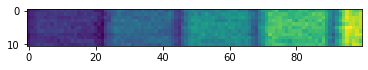

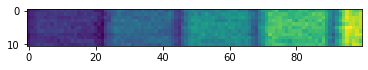

tensor(1.1921e-06, grad_fn=<MaxBackward1>)


In [63]:
diag_tmp = torch.diagonal(tmp, dim1=1, dim2=2)

# FAST METHOD
print(conv.weight.shape)
weigth_sq = conv.weight**2

conv_sq = nnj.ConvTranspose2d(OUT_c,
                              IN_c,
                              kernel_size=(kernel_h,kernel_w),
                              padding=(padding_h,padding_w),
                              stride=stride,dilation=dilation, output_padding=0, bias=None)
print(conv_sq.weight.shape , weigth_sq.shape)
assert conv_sq.weight.shape == weigth_sq.shape
conv_sq.weight = torch.nn.Parameter(weigth_sq)


input_tmp = diag_tmp.reshape(batch_size,OUT_c,OUT_h,OUT_w)
output_tmp = conv_sq._jacobian_mult(torch.zeros(batch_size, OUT_c,OUT_h,OUT_w), 
                                    torch.zeros(batch_size, IN_c, IN_h, IN_w), 
                                    input_tmp)
diag_Jt_tmp_J = output_tmp.reshape(batch_size, IN_size)
print(diag_Jt_tmp_J.shape)


# SLOW METHOD
tmp_simple = torch.diag_embed(diag_tmp)
slow_Jt_tmp_J = torch.einsum('Bji,Bjk,Bkq->Biq', conv_jacobian_wrt_input(), tmp_simple, conv_jacobian_wrt_input())
diag_slow_Jt_tmp_J = torch.diagonal(slow_Jt_tmp_J, dim1=1, dim2=2)
print(diag_slow_Jt_tmp_J.shape)


# compare
plt.imshow(diag_slow_Jt_tmp_J[:,:100].detach().numpy())
plt.show()
plt.imshow(diag_Jt_tmp_J[:,:100].detach().numpy())
plt.show()

print(torch.max(torch.abs(diag_slow_Jt_tmp_J - diag_Jt_tmp_J)))
assert torch.max(torch.abs(diag_slow_Jt_tmp_J - diag_Jt_tmp_J)) < 1e-5